In [46]:
%matplotlib inline
%load_ext autoreload
import numpy as np
import pandas as pd
import matplotlib
from kam11 import context, matchedField, thermister, rayModeling
from beamforming import timeDomain
from kam11.plotting import mfPlotting
import matplotlib.pyplot as plt
import scipy.signal as sig
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
# Beamform on a broadside sinusoidal signal
thetaRange = (-90, 90)
numTheta = 1000
beamformerTime = 2  # ms
c = 1500  # m/s
numEl = 16
# dr = 3.75  # m


# Sinusoidal signal setup
fs = 1e5
resampleRate = 10
fc = 31e3

# Half lambda spacing
dr = c / fc / 2

#figure saving
figSaveDir='/Users/edwardlrichards/cir_processing/sinusoidalBeamformer'

In [48]:
lookTheta = np.r_[thetaRange[0] : thetaRange[1] : numTheta * 1j]
eleZ = np.arange(numEl) * dr
eleZ -= np.median(eleZ)

q = (1 / c) * np.sin(np.radians(lookTheta))
delay = eleZ[:, None] * q[None, :]
delay = pd.DataFrame(delay.T, index = lookTheta, columns = eleZ)

In [49]:
# Generate a time series at the times the length of the beamformer
numSamples = (beamformerTime * 3) / 1e3 * fs
tAxis = np.arange(numSamples) / fs
testSeries = np.sin(2 * np.pi * fc * tAxis)
dataSet = np.tile(testSeries, (numEl, 1)).T
dataSet = pd.DataFrame(dataSet, index=tAxis)

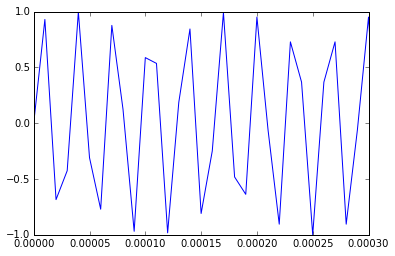

In [50]:
_=plt.plot(tAxis, testSeries)
_=plt.xlim(0,.3e-3)

In [51]:
#Data beamforming
numLookTimes = beamformerTime / 1e3 * fs
lookTimes = np.arange(numLookTimes) / fs + beamformerTime / 1e3
beamD=timeDomain.timeBeamformer(dataSet, lookTimes,
                                delay, upsample=1)

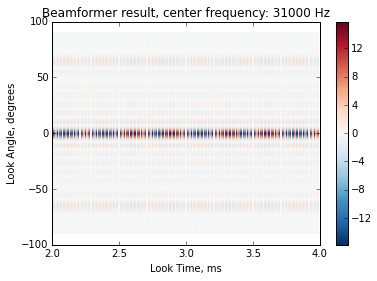

In [52]:
X,Y=np.meshgrid(1e3 * beamD.index, beamD.columns)
_=plt.pcolormesh(X,Y,np.real(beamD).T, cmap=plt.cm.RdBu_r)
_=plt.ylabel('Look Angle, degrees')
_=plt.xlabel('Look Time, ms')
_=plt.colorbar()
_=plt.title('Beamformer result, center frequency: %i Hz'%fc)
savetitle='bf_1x_%i_AllTime'%fc
plt.savefig(os.path.join(figSaveDir, savetitle))

In [53]:
NFFT = int(2 ** np.ceil(np.log2(numLookTimes)))
window = sig.get_window(('kaiser', (3/2)*np.pi), numLookTimes)
winD = window[:,None] * beamD
F = np.fft.rfft(np.real(beamD), NFFT, axis=0)
fAxis=np.arange(F.shape[0]) / (2 * F.shape[0]) * fs

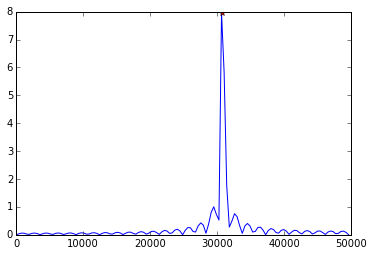

In [54]:
nearestF = np.argmin(np.abs(fAxis-fc)) - 1
_=plt.plot(fAxis, np.abs(F[:,50]))
_=plt.plot(fAxis[nearestF], np.abs(F[nearestF,50]), 'r*')

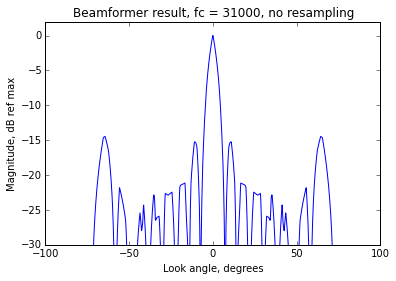

In [55]:
B = 20 * np.log10(np.abs(F[nearestF,:]))
B -= np.max(B)
_=plt.plot(beamD.columns, B)
_=plt.ylim(-30, 2)
_=plt.xlabel('Look angle, degrees')
_=plt.ylabel('Magnitude, dB ref max')
_=plt.title('Beamformer result, fc = %i, no resampling'%fc)
savetitle='bf_1x_%0if'%fc
plt.savefig(os.path.join(figSaveDir, savetitle))

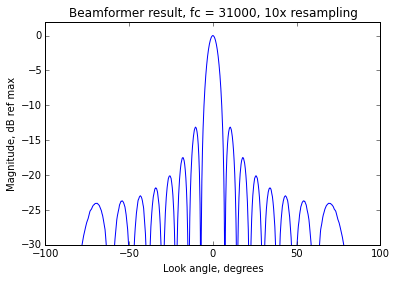

In [56]:
beamDUP = timeDomain.timeBeamformer(dataSet, lookTimes,
                                delay, upsample=10)
FUP = np.fft.rfft(np.real(beamDUP), NFFT, axis=0)
B = 20 * np.log10(np.abs(FUP[nearestF,:]))
B -= np.max(B)
_=plt.plot(beamD.columns, B)
_=plt.ylim(-30, 2)
_=plt.xlabel('Look angle, degrees')
_=plt.ylabel('Magnitude, dB ref max')
_=plt.title('Beamformer result, fc = %i, 10x resampling'%fc)
savetitle='bf_10x_%0if'%fc
plt.savefig(os.path.join(figSaveDir, savetitle))